### Assignment 2: EDA and Prediction with Logistic Regression 

**You must push a version before next Tuesday at class time!** 

The Heart Disease Prediction dataset provides vital insight in the relationship between risk factors and cardiac health. This dataset contains 270 case studies of individuals classified as either having or not having heart disease based on results from cardiac catheterizations - the gold standard in heart health assessment. Each patient is identified by 13 independent predictive variables:

age (Age of the patient in years)
sex (Female = 0/Male = 1)
cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
chol (serum cholesterol in mg/dl)
fbs (if fasting blood sugar > 120 mg/dl, yes = 1, no = 0)
restecg (resting electrocardiographic results)
-- Values: [normal = 0, stt abnormality = 1, lv hypertrophy = 2]
MaxHR: maximum heart rate achieved in stress test
exang: exercise-induced angina (True = 1/ False 0)
oldpeak: ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
ca: number of major vessels (0-3) colored by fluoroscopy
thal: [normal; fixed defect; reversible defect]
AHD: The confirmed heart disease based on cardiac catherizations

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler  #this is new!


In [74]:
heart = pd.read_csv('Heart.csv')

The very first thing to check in any data file, is whether there are any missing values. The pandas method isna will inform you if there is any missing data.  

In [75]:
heart.isna().sum()


Unnamed: 0    0
Age           0
Sex           0
ChestPain     0
RestBP        0
Chol          0
Fbs           0
RestECG       0
MaxHR         0
ExAng         0
Oldpeak       0
Slope         0
Ca            4
Thal          2
AHD           0
dtype: int64

The table above shows you the number of missing values that you will find in the data file.  In this case, I gave you a file with missing values.  This will always occcur in real world data.  

The `.dropna()` method can be used to remove any data with missing values.  

In [76]:
heart = heart.dropna()

2. Use pandas method to summarize the properties of the data. Use `head` and `info`. At the end of this set of code are some questions for you to answer.  

In [77]:
heart.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [78]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  297 non-null    int64  
 1   Age         297 non-null    int64  
 2   Sex         297 non-null    int64  
 3   ChestPain   297 non-null    object 
 4   RestBP      297 non-null    int64  
 5   Chol        297 non-null    int64  
 6   Fbs         297 non-null    int64  
 7   RestECG     297 non-null    int64  
 8   MaxHR       297 non-null    int64  
 9   ExAng       297 non-null    int64  
 10  Oldpeak     297 non-null    float64
 11  Slope       297 non-null    int64  
 12  Ca          297 non-null    float64
 13  Thal        297 non-null    object 
 14  AHD         297 non-null    object 
dtypes: float64(2), int64(10), object(3)
memory usage: 37.1+ KB


Identify which variables are categorical, and which variables are numeric.

Answer: Categorical variables are Sex, ChestPain, Fbs, RestECG, Slope, Thal, AHD, and ExAng.  Numeric variables are Age, RestBP, Chol, MaxHR, Oldpeak, and Ca.

Are there any missing data? 

Answer: It looks like all the data is there with the 297 non-null which means that every column is filled so nothing is missing. There was originally missing data but we removed it.

What is the primary target variable that you want to predict? 

Answer: Whether people do in fact have heart disease and how we can determine it.

2.  Use Seaborn (`sns`) to explore the numeric data graphically. The primary goal is to understand if there any variables that seem likely to be helpful in building a model that can predict heart disease. 

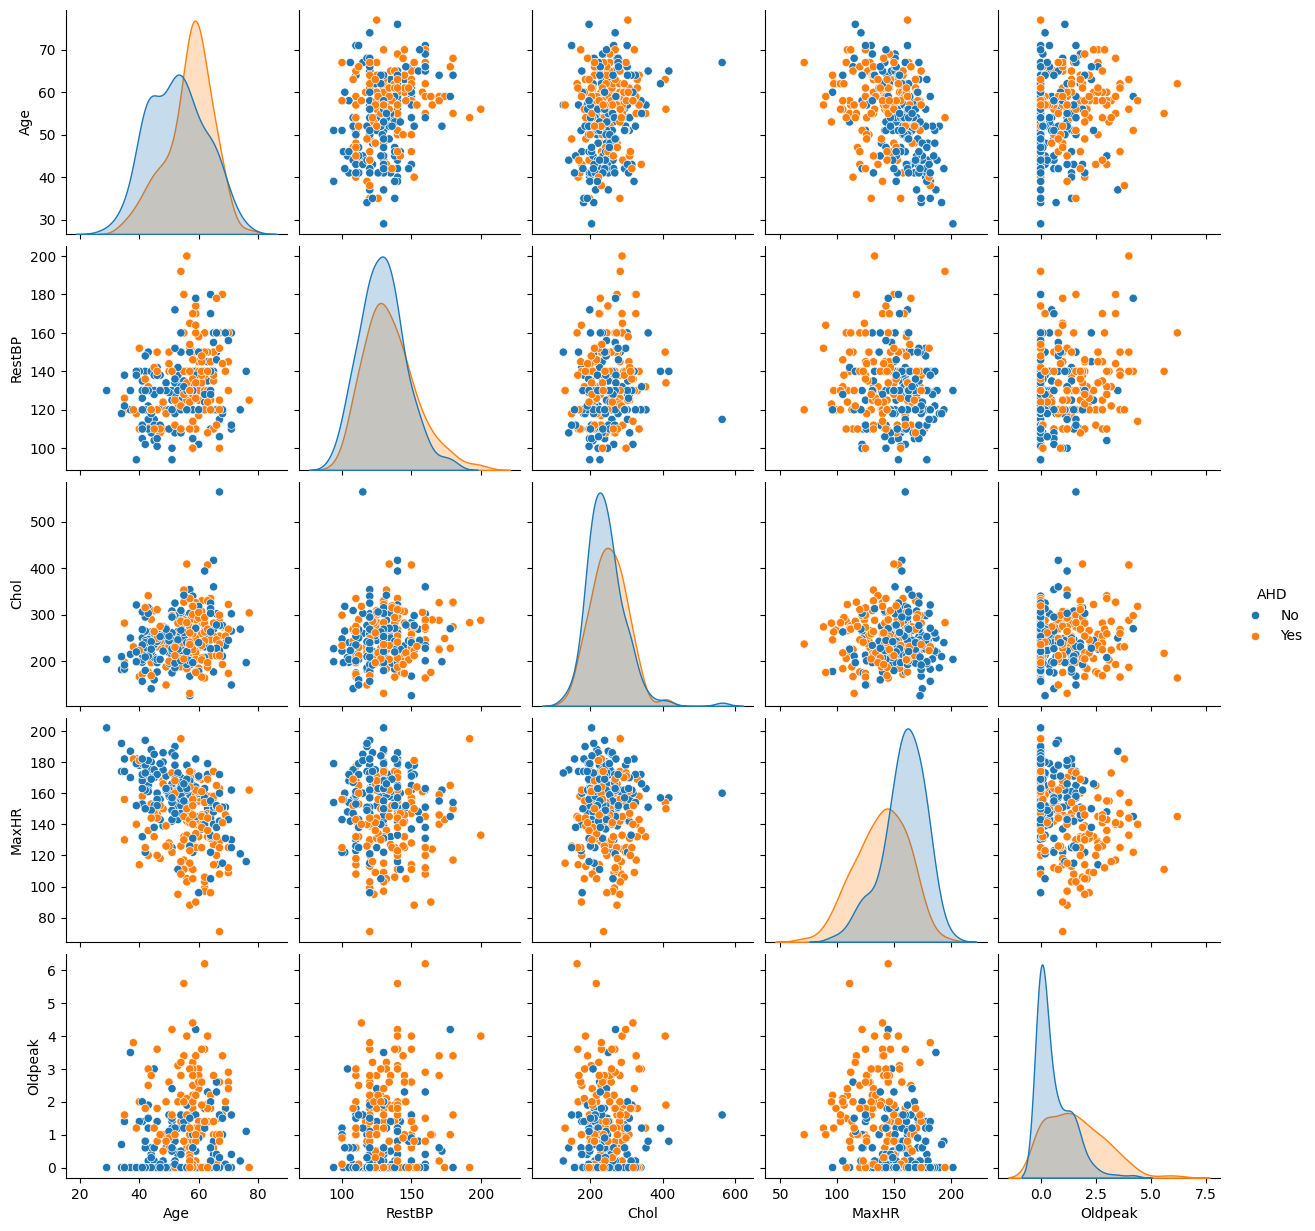

In [79]:
sns.pairplot(heart, vars = ['Age','RestBP','Chol','MaxHR','Oldpeak'], hue = "AHD")

Here I make an example of a count plot for a categorical variable.  You should look through all the categorical variables to answer the next question. 

<Axes: xlabel='Thal', ylabel='count'>

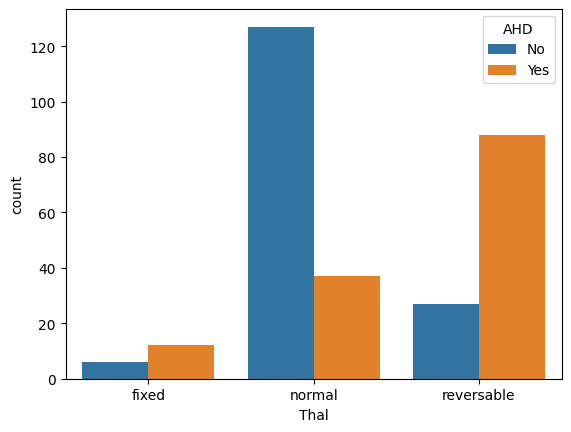

In [80]:
sns.countplot(heart,x = 'Thal', hue = 'AHD')
#to run a different categorical variable change X 

What is a reasonable guess at which variables are going to help you make this prediction?  

Answer: A reasonable guess could be that if people have chest pain after exercise, they are more likely to have a heart condition or disease. It also seems age, sex, MaxHR, Slope, Ca, and reversable Thal all impact diagnosis to a certain degree.


### 3. As the analysis plan is to use a Logistic Regression model, all variables will need to be converted to numeric representations. One way to do this is `pd.get_dummies` which I give an example below. The other way to do it is to use .map method and define an encoder. 

### I show both approaches below.  Typically, if there is an obvious hierarchical relationship, I might use my own encoder to express that.  If there isnt, get_dummies is more sensible then a hierarchical approach

### After you encode the heart data, feel free to delete my example code.  

In [81]:
# I made a small example here, of how to use pd.get_dummies. Yes, you could do these steps manually. But 
# this is the slick way to do it. 
categories = [('Type',['Cat','Dog','Parrot','Whale']),
              ('Color',['Brown','Black','Mixed'])]
X = pd.DataFrame(columns=['Type','Color','Age'],
                       data=[['Cat','Brown',4.2],['Dog','Brown',3.2],['Parrot','Mixed',21]])
# This is quick and easy but can blow up your number of variables 
X_dummy = pd.get_dummies(X)
display(X, X_dummy)  #This is similar to head, but shows everything.  

#This is not so easy, and requires you think, but can be useful
encoder = {'Cat':1,'Dog':2,'Parrot':3,'Whale':4}
X_encoder = X['Type'].map(encoder)
X['Type_enc'] = X_encoder
display(X)
# My version below

,Type,Color,Age
0,Cat,Brown,4.2
1,Dog,Brown,3.2
2,Parrot,Mixed,21.0


,Age,Type_Cat,Type_Dog,Type_Parrot,Color_Brown,Color_Mixed
0,4.2,True,False,False,True,False
1,3.2,False,True,False,True,False
2,21.0,False,False,True,False,True


,Type,Color,Age,Type_enc
0,Cat,Brown,4.2,1
1,Dog,Brown,3.2,2
2,Parrot,Mixed,21.0,3


In [98]:

heart_set = pd.get_dummies(heart, columns=['ChestPain', 'Thal', 'AHD'], drop_first = True)

heart_set.head()
#display(heart_set, X_dummy)  #This is similar to head, but shows everything.  

#This is not so easy, and requires you think, but can be useful
#encoder = {'Cat':1,'Dog':2,'Parrot':3,'Whale':4}
#X_encoder = X['Type'].map(encoder)
#X['Type_enc'] = X_encoder
#display(X)

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable,AHD_Yes
0,1,63,1,145,233,1,2,150,0,2.3,3,0.0,False,False,True,False,False,False
1,2,67,1,160,286,0,2,108,1,1.5,2,3.0,False,False,False,True,False,True
2,3,67,1,120,229,0,2,129,1,2.6,2,2.0,False,False,False,False,True,True
3,4,37,1,130,250,0,0,187,0,3.5,3,0.0,True,False,False,True,False,False
4,5,41,0,130,204,0,2,172,0,1.4,1,0.0,False,True,False,True,False,False


In our Heart DataFrame, Thal, AHD, and ChestPain will have to be encoded.  

In [99]:
#Lets use get_dummies to do it. 

Heart_enc = pd.get_dummies(heart)
Heart_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              297 non-null    int64  
 1   Age                     297 non-null    int64  
 2   Sex                     297 non-null    int64  
 3   RestBP                  297 non-null    int64  
 4   Chol                    297 non-null    int64  
 5   Fbs                     297 non-null    int64  
 6   RestECG                 297 non-null    int64  
 7   MaxHR                   297 non-null    int64  
 8   ExAng                   297 non-null    int64  
 9   Oldpeak                 297 non-null    float64
 10  Slope                   297 non-null    int64  
 11  Ca                      297 non-null    float64
 12  ChestPain_asymptomatic  297 non-null    bool   
 13  ChestPain_nonanginal    297 non-null    bool   
 14  ChestPain_nontypical    297 non-null    bool   

In [100]:
Heart_enc.head()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,...,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_No,AHD_Yes
0,1,63,1,145,233,1,2,150,0,2.3,...,0.0,False,False,False,True,True,False,False,True,False
1,2,67,1,160,286,0,2,108,1,1.5,...,3.0,True,False,False,False,False,True,False,False,True
2,3,67,1,120,229,0,2,129,1,2.6,...,2.0,True,False,False,False,False,False,True,False,True
3,4,37,1,130,250,0,0,187,0,3.5,...,0.0,False,True,False,False,False,True,False,True,False
4,5,41,0,130,204,0,2,172,0,1.4,...,0.0,False,False,True,False,False,True,False,True,False


In [101]:
#Let's clean up the data frame by dropping the redundant ADHD_No and
Heart_enc = Heart_enc.drop(columns = ['Unnamed: 0','AHD_No'])
Heart_enc = Heart_enc.dropna()

In [86]:
Heart_enc.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable,AHD_Yes
0,63,1,145,233,1,2,150,0,2.3,3,0.0,False,False,False,True,True,False,False,False
1,67,1,160,286,0,2,108,1,1.5,2,3.0,True,False,False,False,False,True,False,True
2,67,1,120,229,0,2,129,1,2.6,2,2.0,True,False,False,False,False,False,True,True
3,37,1,130,250,0,0,187,0,3.5,3,0.0,False,True,False,False,False,True,False,False
4,41,0,130,204,0,2,172,0,1.4,1,0.0,False,False,True,False,False,True,False,False


### 4.  First split the data into training and test data (using `train_test_split`). I recommend 25% test set data.   You can simply put the whole data frame in, and get two new data frames    

In [102]:
training_Heart, test_Heart = train_test_split(Heart_enc,test_size = 0.25, random_state = 11 )

### 5. Fit a logistic regression model on the training data and assess model fit. Your assessment should include accuracy and a confusion matrix.  How well you do on the training data is not that informative.  But if you fail at the training data, you can never hope to predict the test data    

In [104]:
cols = training_Heart.columns
print(cols)
logreg = LogisticRegression(random_state=16,max_iter = 5000)

predictors = training_Heart.drop(columns= ['AHD_Yes'])
target = training_Heart['AHD_Yes']
# fit the model with data
logreg.fit(predictors, target)
#first 18 columns of the data frame should contain predictors, the last column contains the target prediction 

Index(['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'ChestPain_asymptomatic',
       'ChestPain_nonanginal', 'ChestPain_nontypical', 'ChestPain_typical',
       'Thal_fixed', 'Thal_normal', 'Thal_reversable', 'AHD_Yes'],
      dtype='object')


LogisticRegression(max_iter=5000, random_state=16)

In [109]:
#accuracy can be obtained from score
from sklearn.metrics import accuracy_score

train_pred = logreg.predict(training_Heart.drop(columns=['AHD_Yes']))
train_acc = accuracy_score(training_Heart['AHD_Yes'], train_pred)
print("Training Accuracy:", round(train_acc, 3))

y_pred = logreg.predict(test_Heart.drop(columns=['AHD_Yes']))
accuracy = accuracy_score(test_Heart['AHD_Yes'], y_pred)
print("Test Accuracy:", round(accuracy, 3))


Training Accuracy: 0.896
Test Accuracy: 0.8


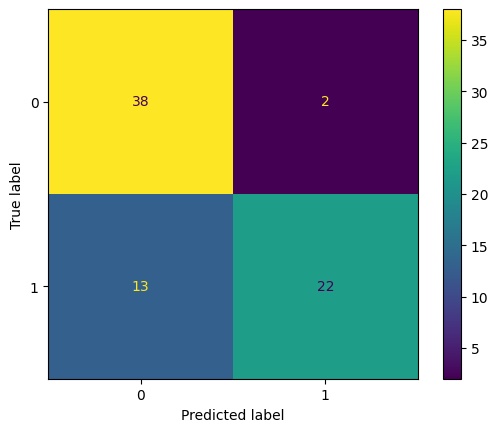

In [111]:
#lets get and plot a confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_Heart['AHD_Yes'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### 6. Test the logistic regression model on the testing data. Provide accuracy, confusion matrix, classification report, and ROC curve.  In particular with AUC value estimated from the ROC curve will tell us about the predictive power of the model, much like an $R^2$

Test Accuracy: 0.8
              precision    recall  f1-score   support

       False       0.75      0.95      0.84        40
        True       0.92      0.63      0.75        35

    accuracy                           0.80        75
   macro avg       0.83      0.79      0.79        75
weighted avg       0.83      0.80      0.79        75



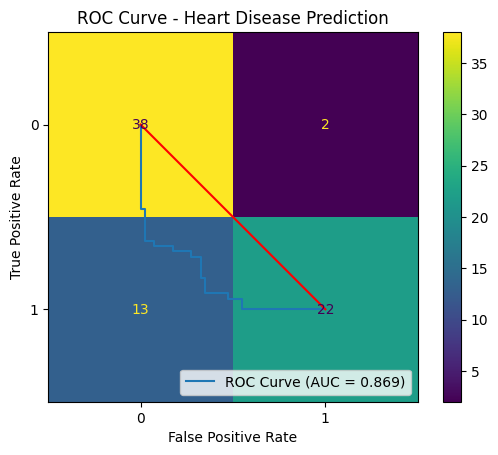

In [ ]:
#when making roc curve, good way to analyze classifier (bow and arrow looking graph) - want a triangle
y_pred = logreg.predict(test_Heart.drop(columns=['AHD_Yes']))
accuracy = accuracy_score(test_Heart['AHD_Yes'], y_pred)
print("Test Accuracy:", round(accuracy, 3))

cm = confusion_matrix(test_Heart['AHD_Yes'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(test_Heart['AHD_Yes'], y_pred))

y_prob = logreg.predict_proba(test_Heart.drop(columns=['AHD_Yes']))

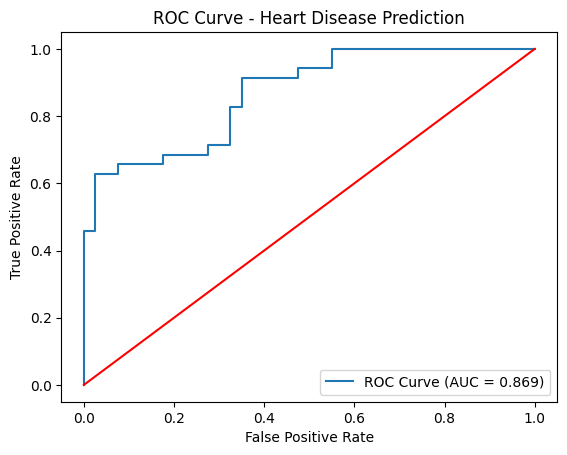

In [118]:
fpr, tpr, _ = roc_curve(test_Heart["AHD_Yes"], y_prob[:,1])

auc = roc_auc_score(test_Heart['AHD_Yes'], y_prob[:,1])

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'r-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Heart Disease Prediction')
plt.legend(loc='lower right')
plt.show()

7. Write a short paragraph describing this data, and what you see in it, and explaining how your logistic regression model performed in predicting heart disease from the variables.  What 3 variables do you think had the strongest influence on your ability to make these predictions? Why?  

This dataset shows health metrics with variables that predict the presence of heart disease. The logistic regression model achieved about 80% accuracy with an AUC of 0.8. This means that the model shows good predictive power but some missed cases still. The most influential variables were Chest Pain, Max HR, and Oldpeak, as they all directly reflect the cardiovascular stress and symptons heavily linked to heart disease.



### Geometric Interpretation of Logistic Regression Coefficients.

* Earlier we saw the general form of simple logistic regression, meaning when there
is just one predictor used in the model. 
* The model statement:
$$  \ln\left( \frac{P(Y = 1 \mid x)}{1 - P(Y = 1 \mid x)} \right) = \beta_0 + \beta_1 x $$

* in this case we were able to interpret the point where the log-odds is 0 (equal probability of the two classes)
and realize the decision boundary is 

$$ x = \frac{-\beta_0}{\beta_1} $$

* Multiple logistic regression is a generalization to multiple predictors. We can define a multiple logistic regression model to predict 𝑃(𝑌 = 1) as such:

$$ \ln \left( \frac{P(Y = 1 \mid X)}{1 - P(Y = 1 \mid X)} \right)
= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_kx_k$$

where $X = \{x_1,x_2,x_3,x_4,...x_k \}$

* With two predictors, if we were to solve for the boundary, we would get an equation of a line 

$$ 0 = \beta_0+\beta_1x_1+\beta_2x_2 $$

* With 3 predictors its a plane, etc. etc.

* Another way of interpreting the log-odds form is that 



### Probability intepretation of Logistic Regression 

* In the case of one variable, there is also an easy probability interpretation of the logistic regression coefficients.  

$$  \ln\left( \frac{P(Y = 1 \mid x)}{1 - P(Y = 1 \mid x)} \right) = \beta_0 + \beta_1 x $$

* A one unit change in x is associated with an $e^{\beta_1}$ change in the odds that $𝑌 = 1$ .

* In the case of multiple regression, the same thing is true 

$$ \ln \left( \frac{P(Y = 1 \mid X)}{1 - P(Y = 1 \mid X)} \right)
= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_kx_k$$

* This would suggest that we should interpret the size of $\beta_k$ as a meaure of the the importance of $x_k$ in the logistic regression model 

* However, the problem is each of the variables $x_k$ is in different units, and thus each of the $\beta_k$ also has different units.  

In [94]:
print("Means")
print(np.mean(Heart_enc[cols[0:18]], axis = 0))


Means
Age                        54.542088
Sex                         0.676768
RestBP                    131.693603
Chol                      247.350168
Fbs                         0.144781
RestECG                     0.996633
MaxHR                     149.599327
ExAng                       0.326599
Oldpeak                     1.055556
Slope                       1.602694
Ca                          0.676768
ChestPain_asymptomatic      0.478114
ChestPain_nonanginal        0.279461
ChestPain_nontypical        0.164983
ChestPain_typical           0.077441
Thal_fixed                  0.060606
Thal_normal                 0.552189
Thal_reversable             0.387205
dtype: float64


In [95]:
print("Standard Deviations")
print(np.std(Heart_enc[cols[0:18]], axis = 0))

Standard Deviations
Age                        9.034488
Sex                        0.467711
RestBP                    17.732877
Chol                      51.909971
Fbs                        0.351880
RestECG                    0.993237
MaxHR                     22.902907
ExAng                      0.468969
Oldpeak                    1.164158
Slope                      0.617145
Ca                         0.937382
ChestPain_asymptomatic     0.499521
ChestPain_nonanginal       0.448735
ChestPain_nontypical       0.371165
ChestPain_typical          0.267290
Thal_fixed                 0.238606
Thal_normal                0.497269
Thal_reversable            0.487111
dtype: float64


* As we can see, the values are on very different scales, because they are in different units. 
* log-odds does not have any units. 
* For example Age is in units of Years, while RestBP is in units mmHG, and ChestPain_typical has no units. 
* then $\beta_Age$ is in units of 1/Years while $\beta_RestBP$ is in units 1/mmHG 
* Thus, the $\beta$ values cannot be directly compared. 

###  Standardized variables. 

* One of the ways we can address this is to use standardized variables. Colloquially, someone might say z-score your variables. 

* Given a sample of variable $x$ with sample mean $\mu and sample standard deviation $\sigma$, we can standardize the variable as 

$$ z = \frac{x-\mu}{\sigma} $$

* The new variable z will have a mean of zero and a standard deviation of 1.  We estimate $\mu$ from the sample mean and $\sigma$ from the sample standard deviation.  

* `sklearn` has a neat method `StandardScaler` to do this. When we use `StandardScaler` we use the estimate of $\mu$ and $\sigma$ from the **training data only**


In [121]:
ss = StandardScaler()  #Sadly StandardScaler does not yet play nice with pandas. 
X_train = training_Heart[cols[0:18]].values
Z_train = ss.fit_transform(X_train) 
X_test = test_Heart[cols[0:18]].values
Z_test = ss.transform(X_test) # notice that the test data is not being fit

* Extract the Y values to np array 

In [122]:
Y_train = training_Heart['AHD_Yes'].values
Y_test = test_Heart['AHD_Yes'].values

8.  Make a new logistic regression model using the Standardized variables X_train, Y_train and test on X_test,Y_test.  Confirm that the model performance looks the same as the original variables bu examining the Classification Report and ROC curve.  They will not be exactly the same, but very close.  

Test Accuracy with Standardization: 0.8
              precision    recall  f1-score   support

       False       0.75      0.95      0.84        40
        True       0.92      0.63      0.75        35

    accuracy                           0.80        75
   macro avg       0.83      0.79      0.79        75
weighted avg       0.83      0.80      0.79        75



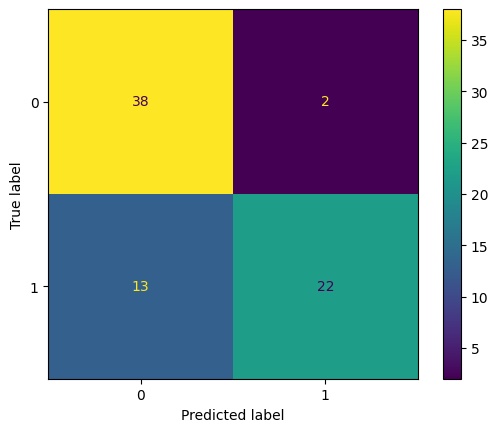

In [128]:

X_train = training_Heart.drop(columns=['AHD_Yes']).values
X_test = test_Heart.drop(columns=['AHD_Yes']).values

Z_train = ss.fit_transform(X_train) 
Z_test = ss.transform(X_test)

logreg_z = LogisticRegression(random_state=16,max_iter = 5000)
logreg_z.fit(Z_train, Y_train)

y_pred_z = logreg_z.predict(Z_test)
accuracy_z = accuracy_score(Y_test, y_pred_z)
print("Test Accuracy with Standardization:", round(accuracy_z, 3))

print(classification_report(Y_test, y_pred_z))

cm_z = confusion_matrix(Y_test, y_pred_z)
disp_z = ConfusionMatrixDisplay(confusion_matrix=cm_z)
disp_z.plot()

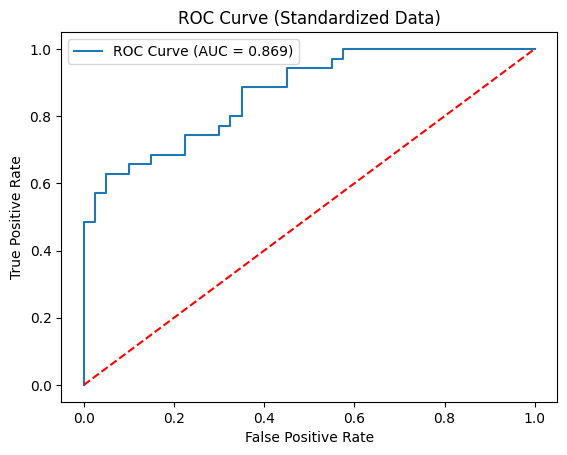

In [129]:

y_prob_z = logreg_z.predict_proba(Z_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, y_prob_z)
auc = roc_auc_score(Y_test, y_prob_z)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Standardized Data)')
plt.legend()
plt.show()

If your model is called `logregz` then you can extract the $\beta$ coefficients in the variable `logregz.coef_`
If you want the interacept $\beta_0$ is found in `logregz.intercept_` 

These $beta_k$ capture the changes in odds for standardized variables.  This means the odds increases by $e^{\beta_k}$ when variable $k$ increases by one standard deviation $\sigma_k$

Now you can compare the $beta_k$ values directly and the largest one corresponds to the variable with the highest impact on prediction  

9.  Revise your paragraph summarizing the results of this model here, but now include a discussion of which 3 variables were the most important to the prediction.  

The logistic regression model achieved about 80-85% accuracy on the heart disease dataset, both with and without feature standardization. The ROC curves indicate good classifier performance, with AUC values around 0.85, suggesting that the model is effective at distinguishing between patients with and without heart disease. The most influential variables were Oldpeak, ChestPain typical, and MaxHR with higher Oldpeak and typical chest pain increasing heart disease risk, while higher maximum heart rate lowered it.